In [1]:
from jedi import jedi
from jedi.utils import plot, seedutil, func_generator

import random
import types
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from __future__ import division
from scipy.integrate import odeint, ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace, \
    cos,pi,hstack,zeros_like,abs,repeat
from numpy.random import uniform,normal,choice

from ipywidgets import interact, fixed
from sklearn.decomposition import PCA

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [58]:
reload(jedi)
reload(seedutil)

<module 'jedi.utils.seedutil' from '/Users/simonhaxby/Code/Python/jedi/utils/seedutil.pyc'>

In [3]:
# Setting Seeds
seeds = random.sample(range(100000), 1)

### Comparing thresholds

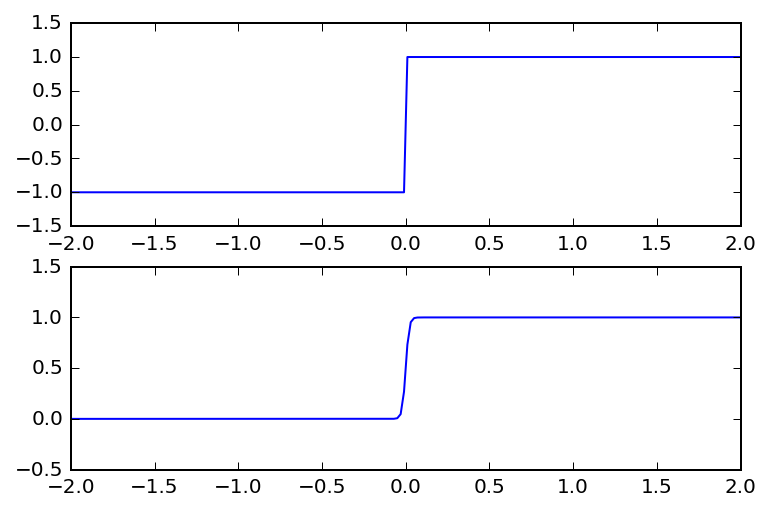

In [40]:
rho = 0
t = linspace(-2,2,200)
plt.subplot(2,1,1)
plt.plot(t, jedi.step_decode(t));
plt.ylim(-1.5,1.5)

rho = 100
plt.subplot(2,1,2)
plt.plot(t, jedi.sigmoid(t, rho));
plt.ylim(-.5,1.5);

# Test Signals

## 1) Sin Wave

In [21]:
# sine-wave target
target = lambda t0: cos(2 * pi * t0/.5)

In [29]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 10   # simulation length
tstop = 5  # learning stop time
g = 1.5    # gain factor?
N = 200      # size of stochastic pool
lr = 1   # learning rate

In [63]:
reload(jedi)
reload(seedutil)

<module 'jedi.utils.seedutil' from '/Users/simonhaxby/Code/Python/jedi/utils/seedutil.pyc'>

In [99]:
errors = []

for seedling in seeds:
    J, Wz, _, x0, u, w = seedutil.set_simulation_parameters(seedling, N, 1, (.1,1,1))
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z): 
        return (-x + g * dot(J, tanh_x) + Wz*z)/dt 
    
    x,t,z,_,wu,_ = jedi.force(target, model, lr, dt, tmax, tstop, x0, w)

    error = np.abs(z-target(t))
    errors.append(error)
    
errors = np.array(errors)

Simulation run-time (wall): 1.379 seconds


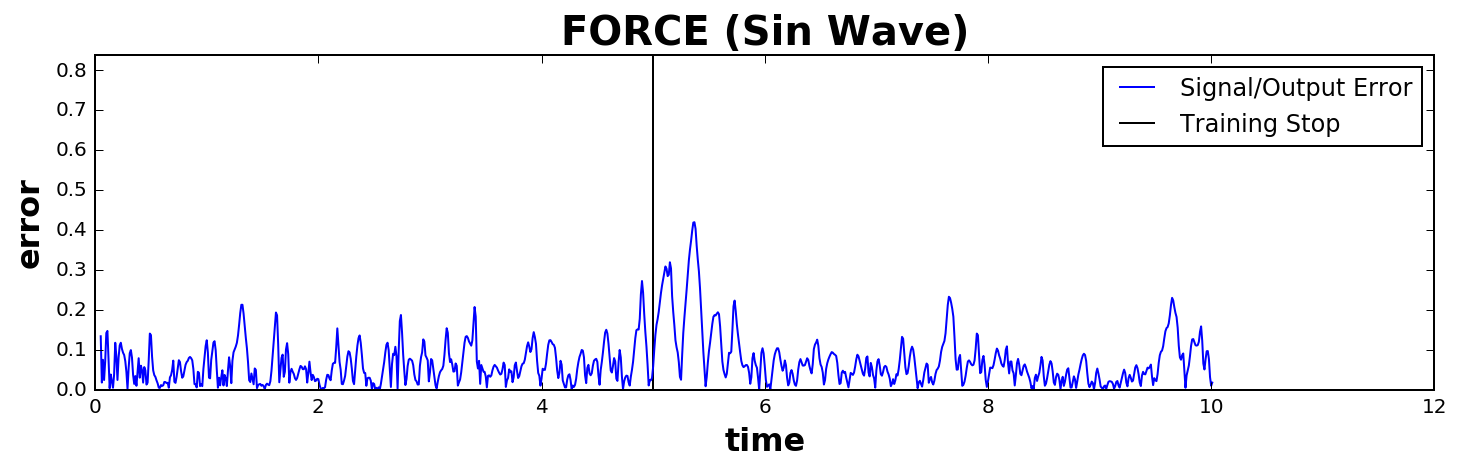

In [32]:
plt.figure(figsize=(12,3))
plot.signal_error(errors, t, tstop, title= "FORCE (Sin Wave)", burn_in=5)

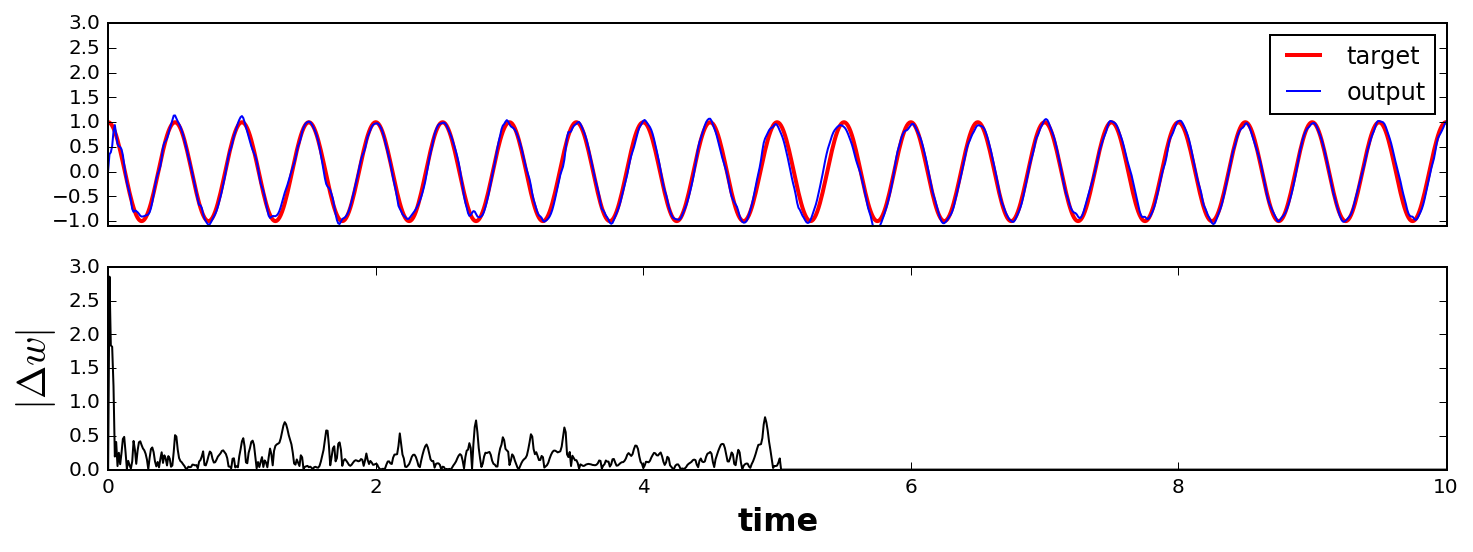

In [33]:
plt.figure(figsize=(12,4))
plot.target_vs_output_plus_error(t, z, wu, target, offset=1, log=False)

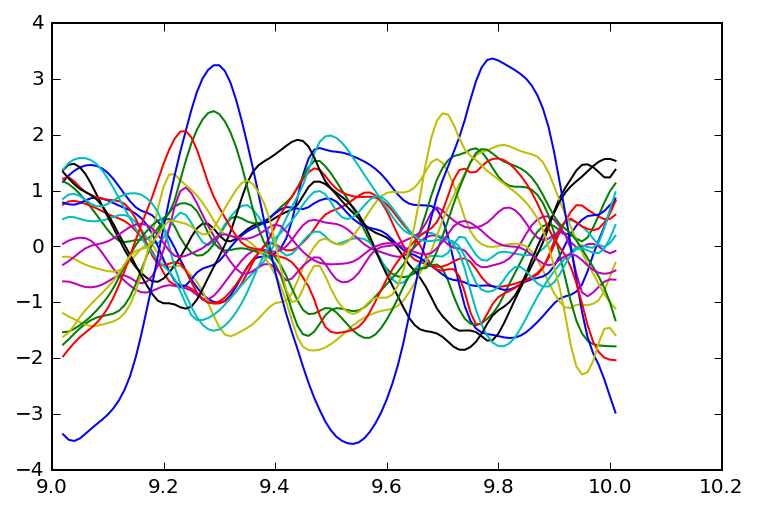

In [34]:
# Visualizing activities of first 20 neurons
for i in range(20):
    plt.plot(t[-100:], x[-100:, i]);

In [35]:
pca = PCA(n_components=2)
pca.fit(x)
pca_x = pca.transform(x).T

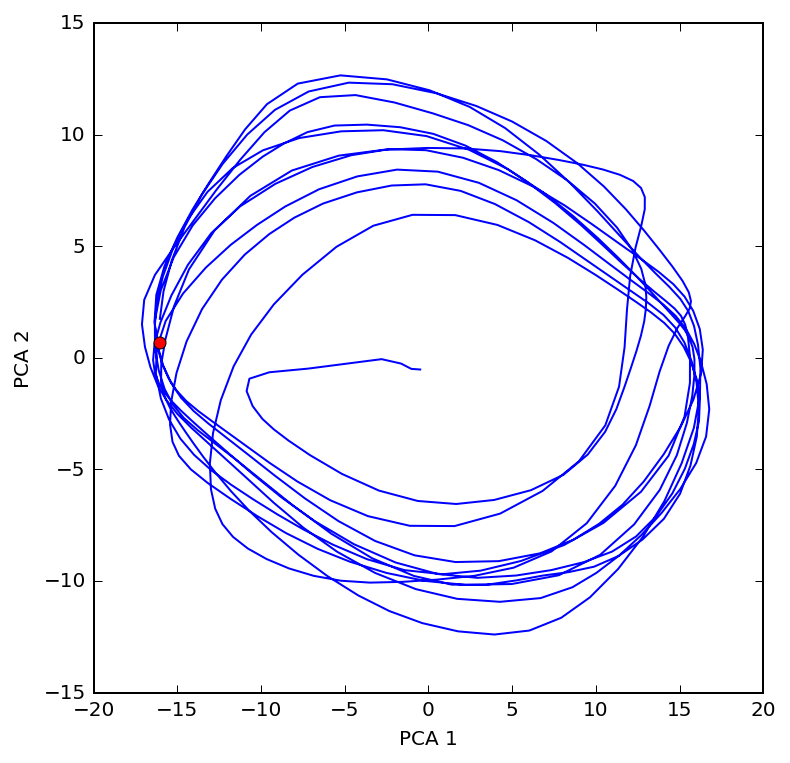

In [36]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_2dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

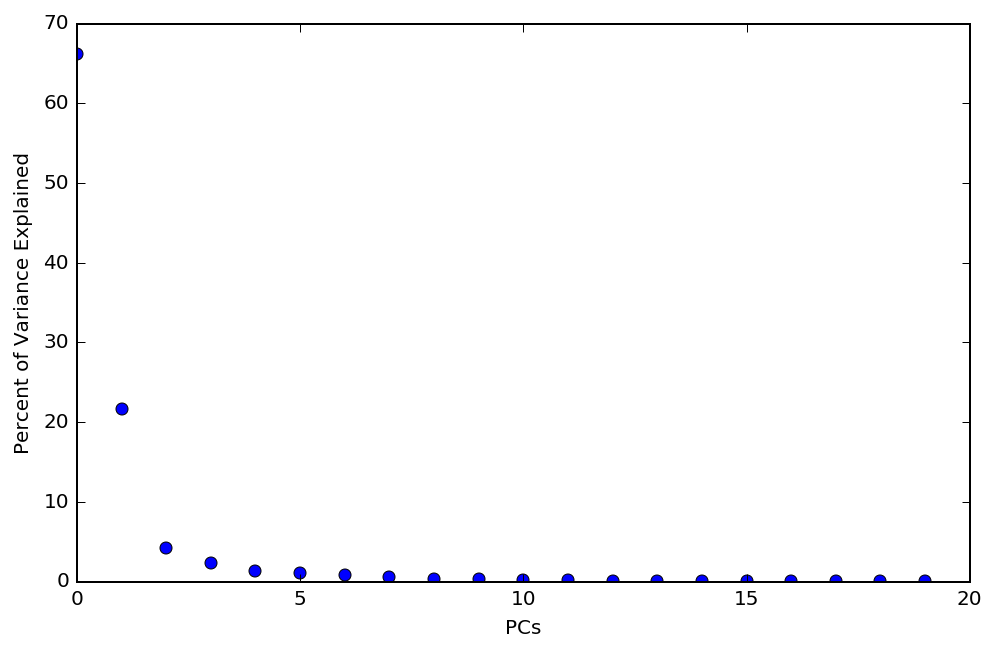

In [37]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");

In [102]:
reload(jedi)
reload(seedutil)

<module 'jedi.utils.seedutil' from '/Users/simonhaxby/Code/Python/jedi/utils/seedutil.pyc'>

In [103]:
# simulation parameters for SFORCE
dt = .01       # time step
tmax = 10   # simulation length
tstop = 5  # learning stop time
g = 1.5     # gain factor?
N = 200    # size of stochastic pool
lr = 1     
rho = 100

In [108]:
derrors = []

for seed in seeds:
    J, Wz, _, x0, u, w = seedutil.set_simulation_parameters(seed, N, 1, (.9,1,1))
    
    def model(t0, x, tanh_x, inp, z): 
        return (-x + g * dot(J, tanh_x) + Wz*z)/dt 
    
    x,t,z,_,wu,_ = jedi.dforce(jedi.sigmoid, rho, target, model, lr, dt, tmax, tstop, x0, w)

    derror = np.abs(z-target(t))
    derrors.append(derror)
    
derrors = np.array(derrors)

Simulation run-time (wall): 1.370 seconds


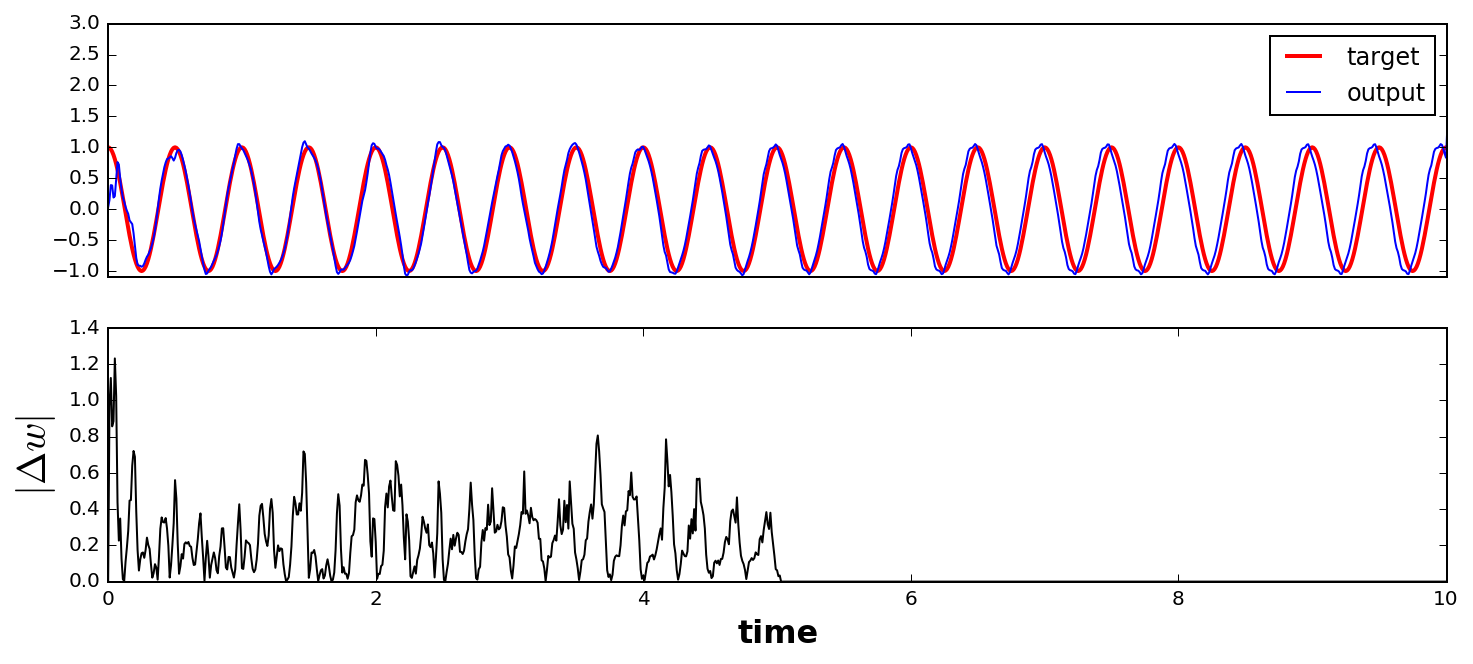

In [109]:
plt.figure(figsize=(12,5))
plot.signal_error(derrors, t, tstop, title="SFORCE (Sin Wave)", burn_in=5)
plot.target_vs_output_plus_error(t, z, wu, target, offset=1, log=False)

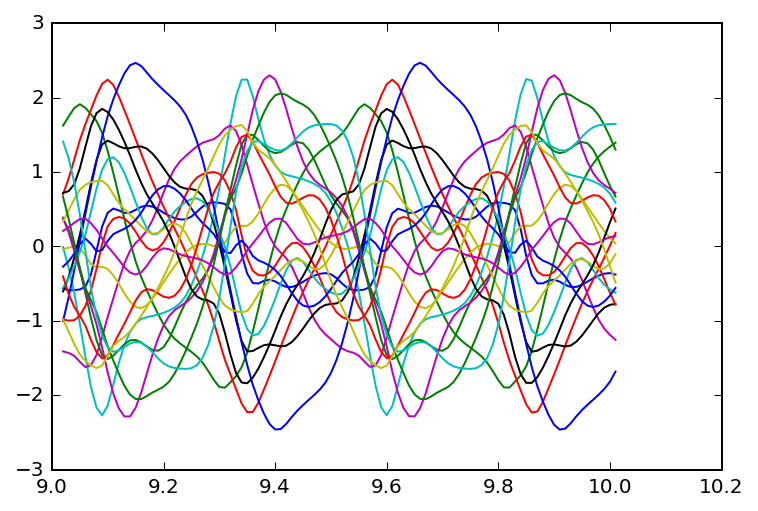

In [107]:
for i in range(20):
    plt.plot(t[-100:], x[-100:, i]);

In [ ]:
pca = PCA(n_components=2)
pca.fit(x)

In [ ]:
pca_x = pca.transform(x).T

In [ ]:
tmax = t[-1]
tmin = t[0]
tv = t

interact(visualize_2dim_state, time=(tmin, tmax, .1));

In [ ]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("SFORCE (Sin Wave)");

In [ ]:
plt.figure(figsize=(12,3))
plot.cross_signal_error(errors, derrors, t, tstop, 
                        title="FORCE vs SFORCE (Sin Wave))", burn_in=100)

## 2) 1D Flip-Flop

In [78]:
reload(func_generator)

<module 'jedi.utils.func_generator' from '/Users/simonhaxby/Code/Python/jedi/utils/func_generator.py'>

In [77]:
max(((1/100)*tmax)/dt, 2)

100.0

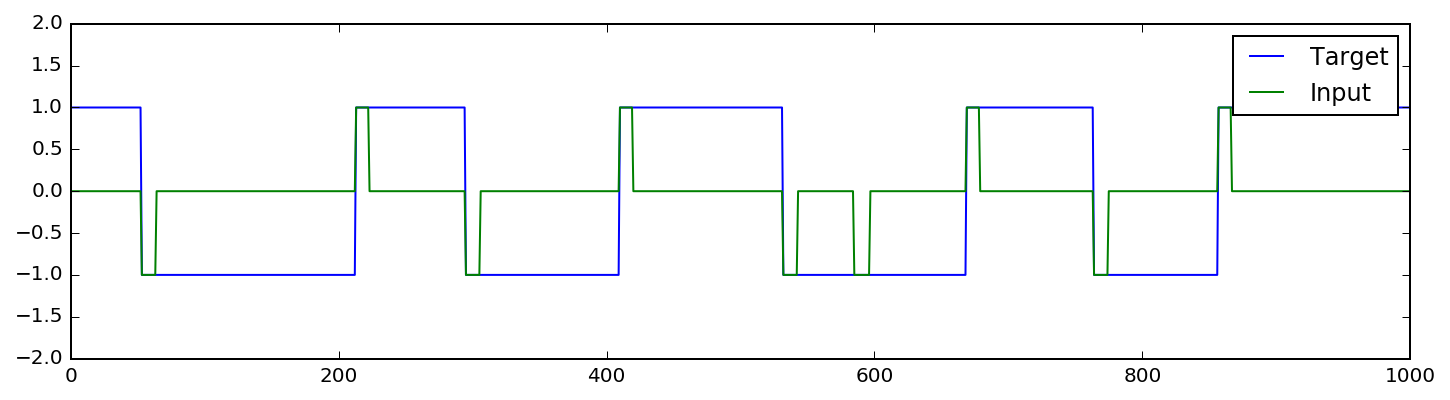

In [100]:
# Plotting inputs and targets
tmax = 10
dt = .01
n = 1

inputs, targets = func_generator.flip_flop_generator(n=n, spikes=[[5,5] for _ in range(n)], t=tmax, dt=dt)
scale = 3
plt.figure(figsize=(12, scale*n))
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(range(int(tmax/dt)), targets[i], label="Target");
    plt.plot(range(int(tmax/dt)), inputs[i], label="Input");
    plt.ylim(-2,2);
    plt.legend();

In [7]:
targets = np.load("../data/stability/flipflop/targets_tmax10sec.npy")
inputs = np.load("../data/stability/flipflop/inputs_tmax10sec.npy")

In [30]:
dt = .01       # time step
tmax = 10  # simulation length
tstop = 5  # learning stop time
g = 1.5      # gain factor?
N = 100     # size of stochastic pool
I = 1    # input size
lr = 1     # learning rate

In [31]:
errors = []
wus = []
zs = []

for seed in seeds:
    J, Wz, Wi, x0, u, w = seedutil.set_simulation_parameters(seed, N, I, p=(.1,1,1))
    
    def model(t0, x, tanh_x, inp, z):
        return (-x + dot(J, tanh_x) + dot(Wi, inp) + Wz*z)/dt
    
    x,t,z,_,wu,_ = jedi.force(targets, model, lr, dt, tmax, tstop, x0, w, inputs)
    
    zs.append(z)
    wus.append(wu)
    
    error = np.abs(z-np.array(targets))
    errors.append(error)
    
errors = np.array(errors)

Simulation run-time (wall): 0.600 seconds


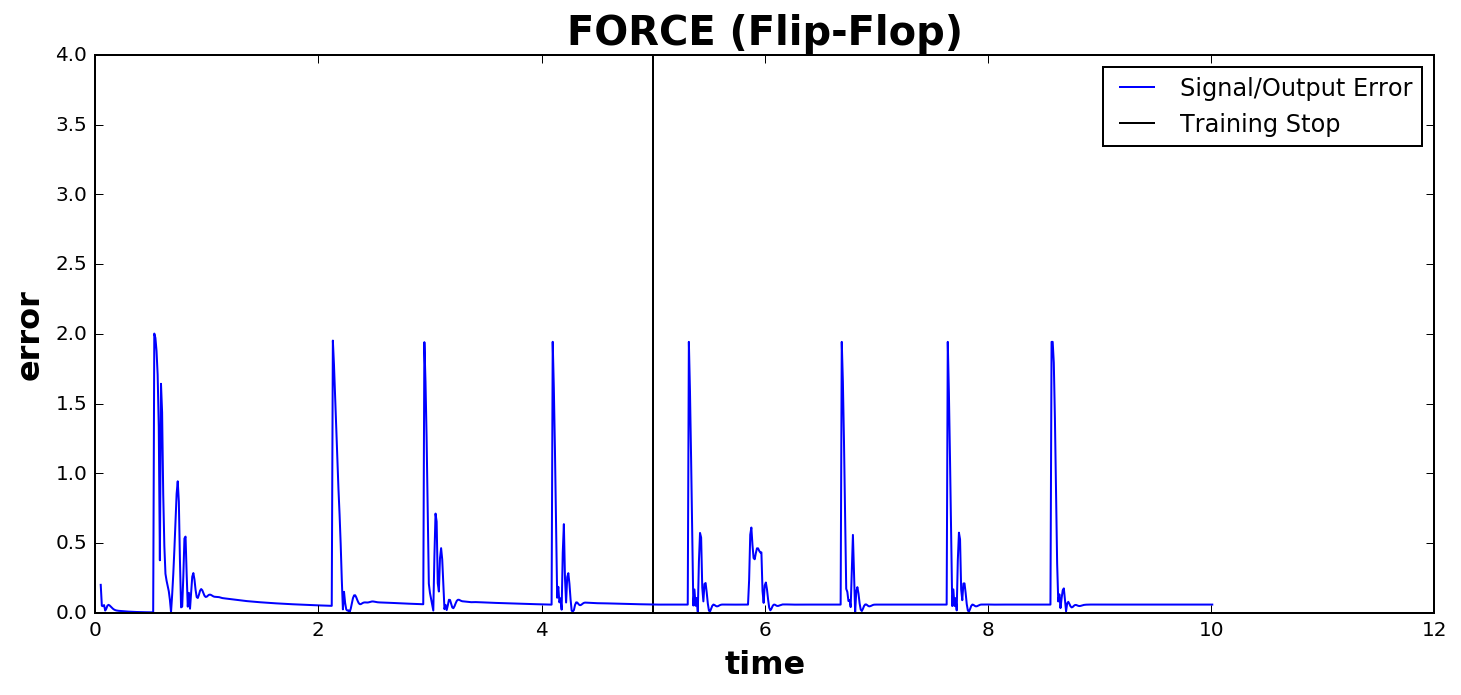

In [32]:
plt.figure(figsize=(12,5))
plot.signal_error(errors, t, tstop, title= "FORCE (Flip-Flop)", burn_in=5)

In [33]:
ind = 0

Seed: 0


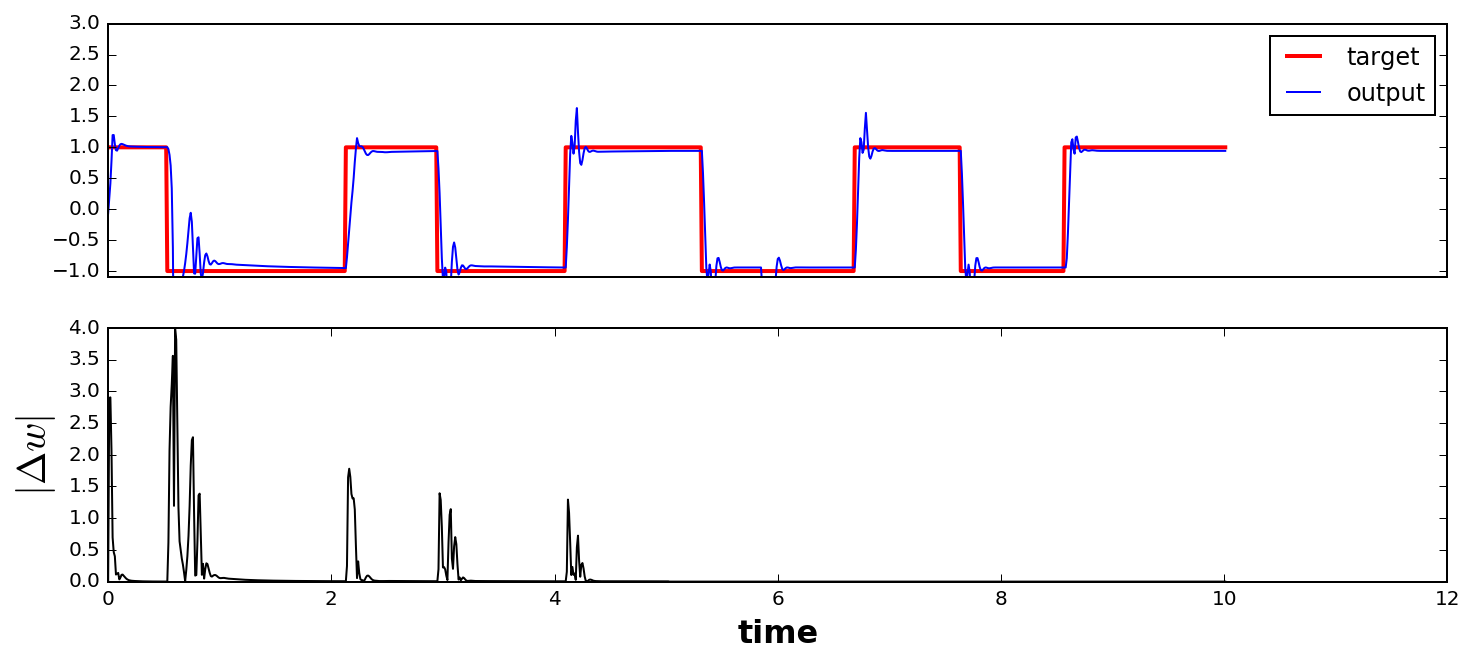

In [34]:
plt.figure(figsize=(12,5))
if ind < len(seeds):
    print("Seed: %d" % ind)
    plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=0, log=False)
    ind+=1

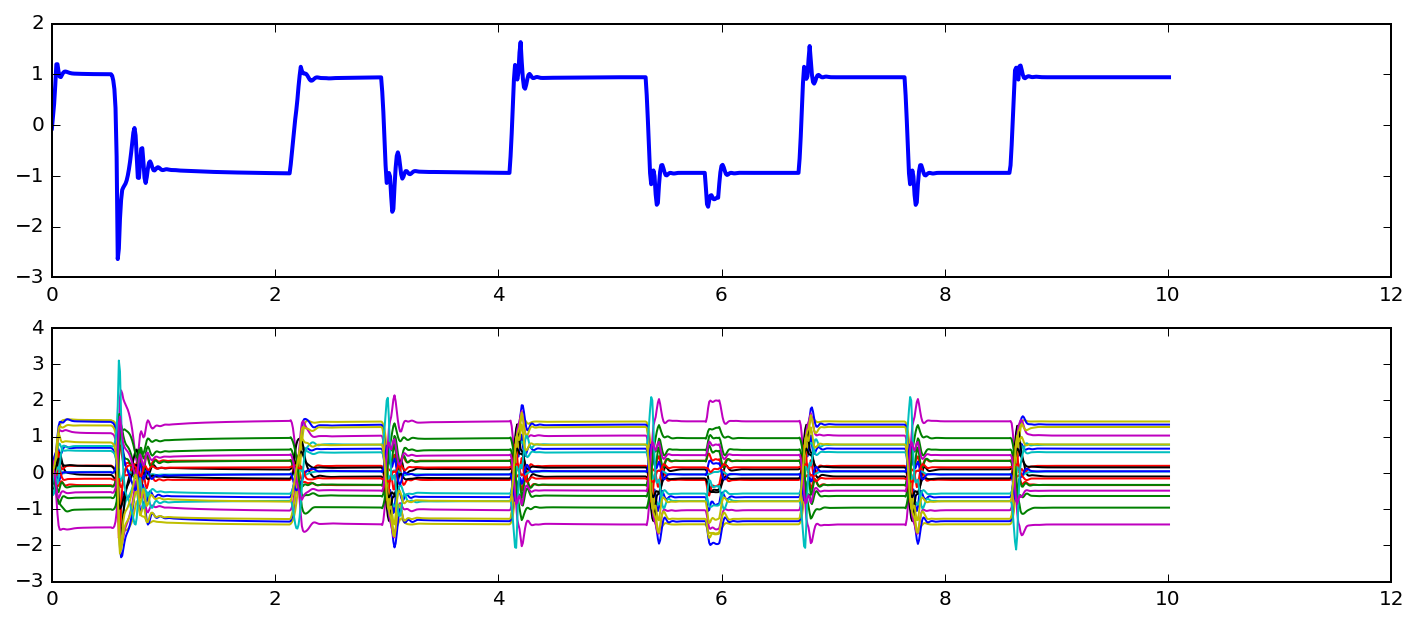

In [35]:
plt.figure(figsize=(12,5))
plt.legend()
plt.subplot(2,1,2)
for i in range(20):
    plt.plot(t[:], x[:, i]);
plt.subplot(2,1,1)
plt.plot(t, np.array(z), lw=2, label="output");

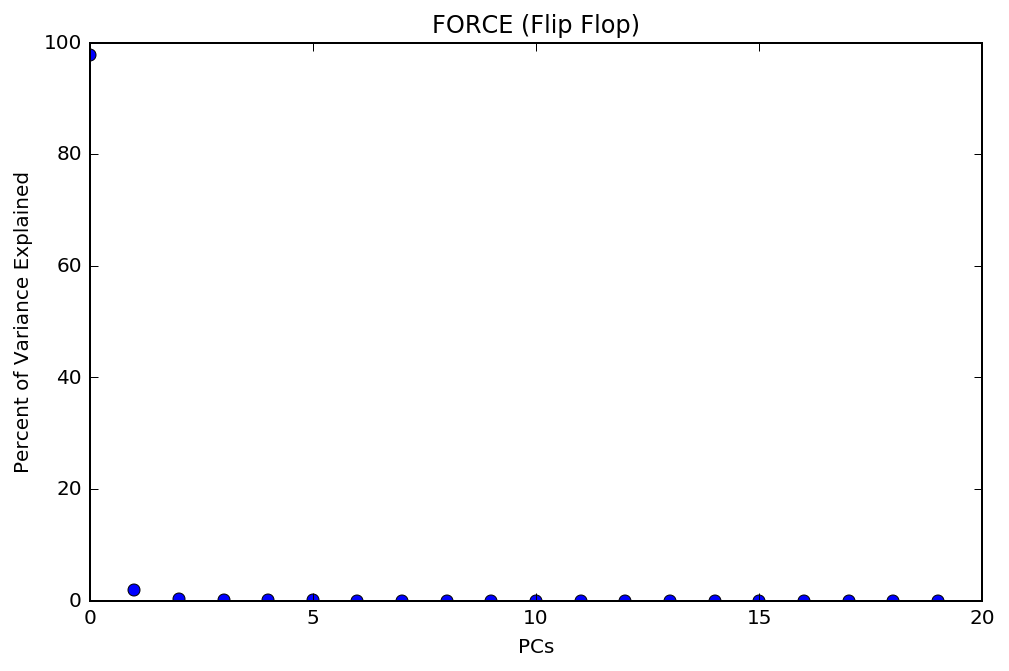

In [36]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("FORCE (Flip Flop)");

In [37]:
pca = PCA(n_components=2)
pca.fit(x)
pca_x = pca.transform(x).T

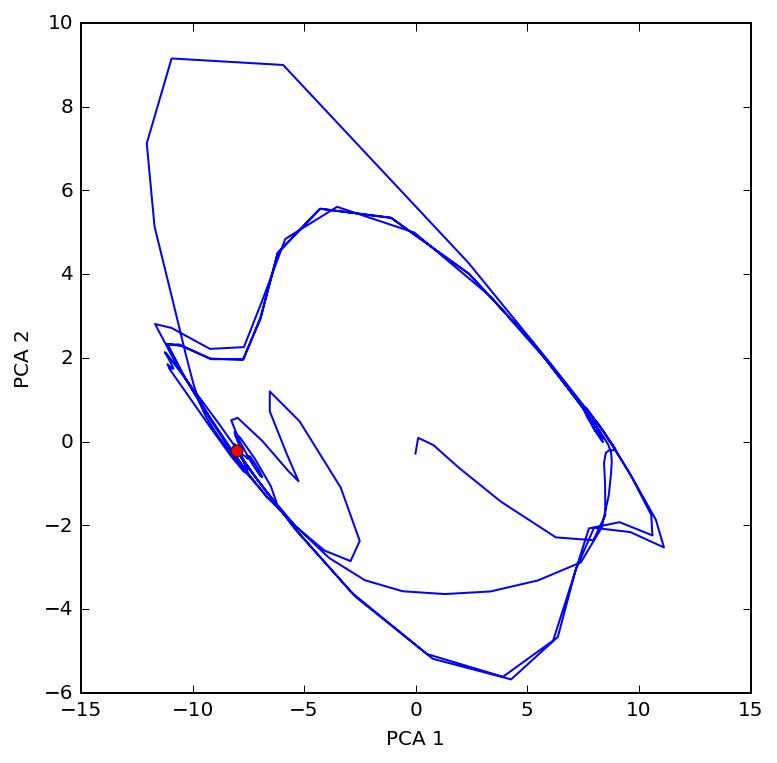

In [38]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_2dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

In [11]:
dt = .01       # time step
tmax = 10   # simulation length
tstop = 5  # learning stop time
g = 1.5      # gain factor?
N = 1000     # size of stochastic pool
I = 1    # input size
lr = 1    # learning rate
rho = 100

In [12]:
derrors = []
wus = []
zs = []

for seed in seeds:
    J, Wz, Wi, x0, u, w = seedutil.set_simulation_parameters(seed, N, I, p=(.1,1,1))
    
    def model(t0, x, tanh_x, inp, z):
        return (-x + dot(J, tanh_x) + dot(Wi, inp) + Wz*z)/dt
    
    
    x,t,z,_,wu,_ = jedi.sforce(rho, targets, model, lr, dt, tmax, tstop, x0, w, inputs)

    zs.append(z)
    wus.append(wu)
        
    derror = np.abs(z-np.array(targets))
    derrors.append(derror)
    
derrors = np.array(derrors)

Simulation run-time (wall): 50.024 seconds


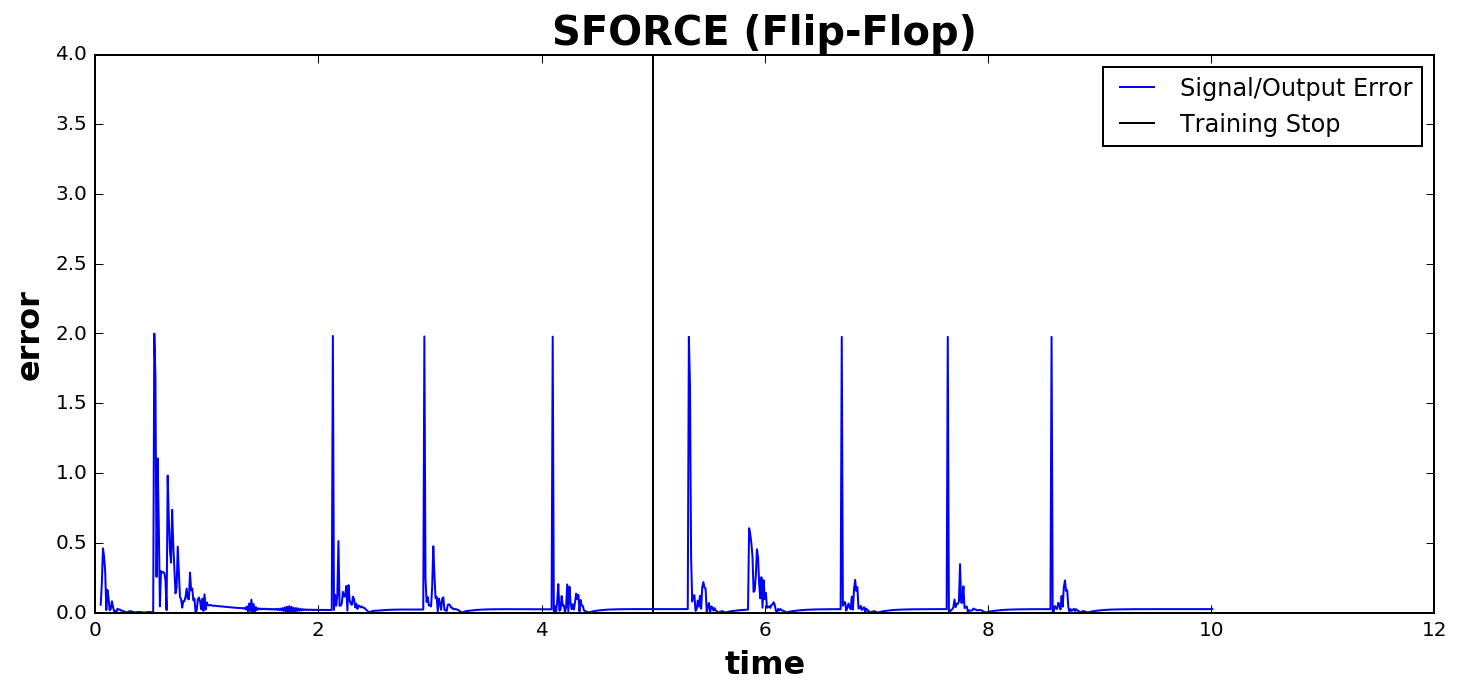

In [14]:
plt.figure(figsize=(12,5))
plot.signal_error(derrors, t, tstop, title="SFORCE (Flip-Flop)", burn_in=5)

In [15]:
# Setting seed index
ind = 0

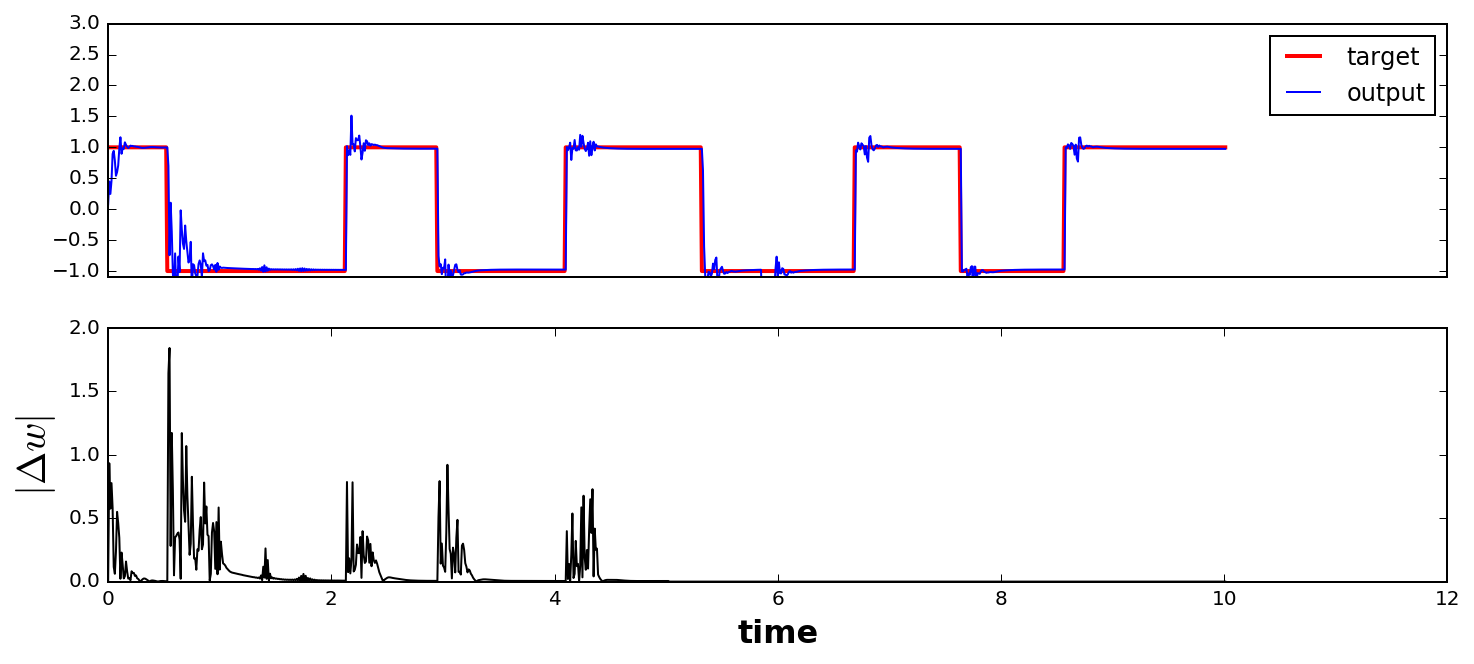

In [20]:
plt.figure(figsize=(12,5))
plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=0, log=False)

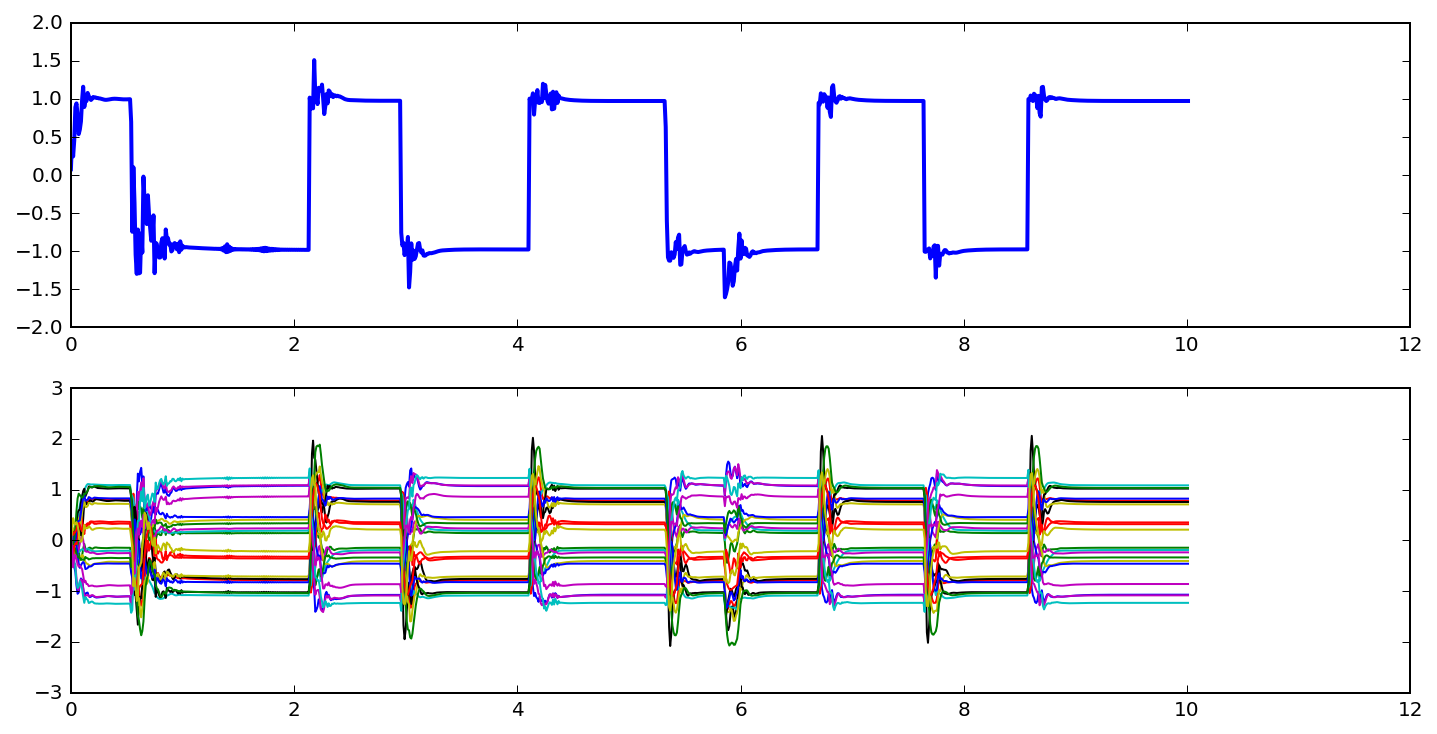

In [23]:
plt.figure(figsize=(12,6))
plt.legend()
plt.subplot(2,1,2)
for i in range(20):
    plt.plot(t[:], x[:, i]);
plt.subplot(2,1,1)
plt.plot(t, np.array(z), lw=2, label="output");

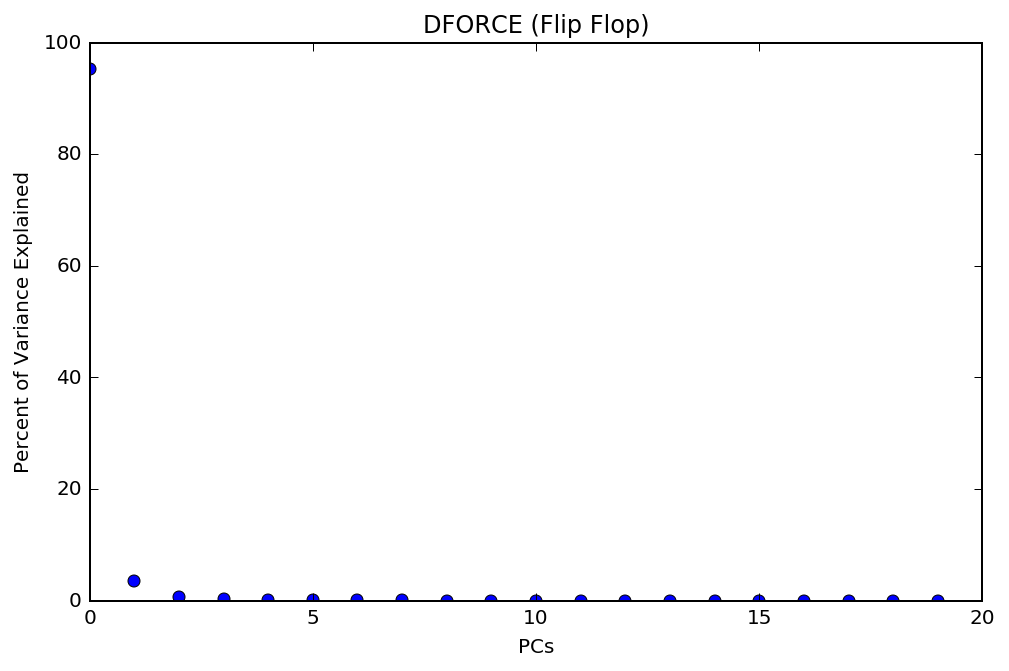

In [24]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("DFORCE (Flip Flop)");

In [25]:
pca = PCA(n_components=2)
pca.fit(x)
pca_x = pca.transform(x).T

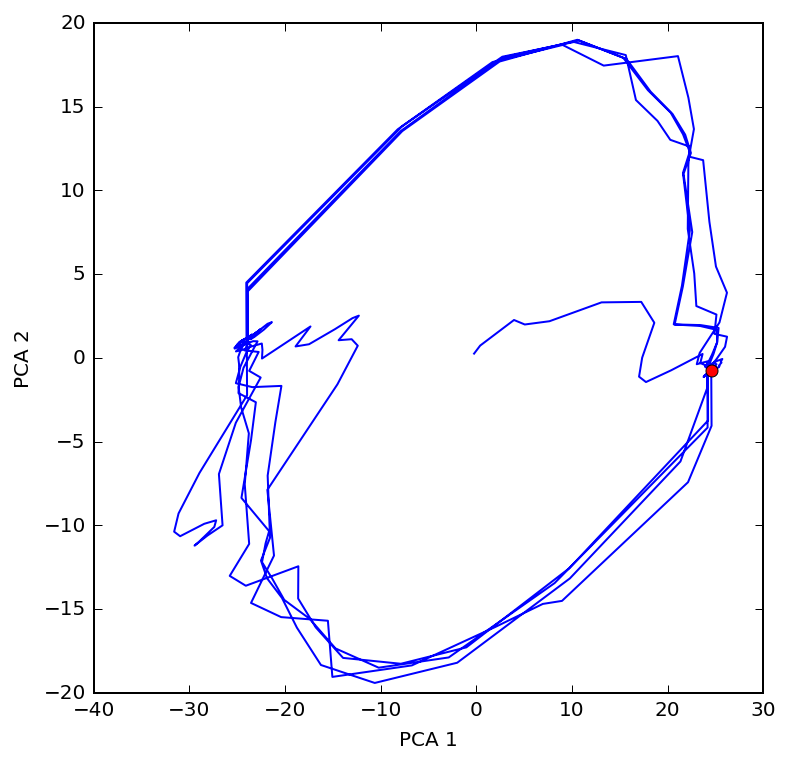

In [28]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_2dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

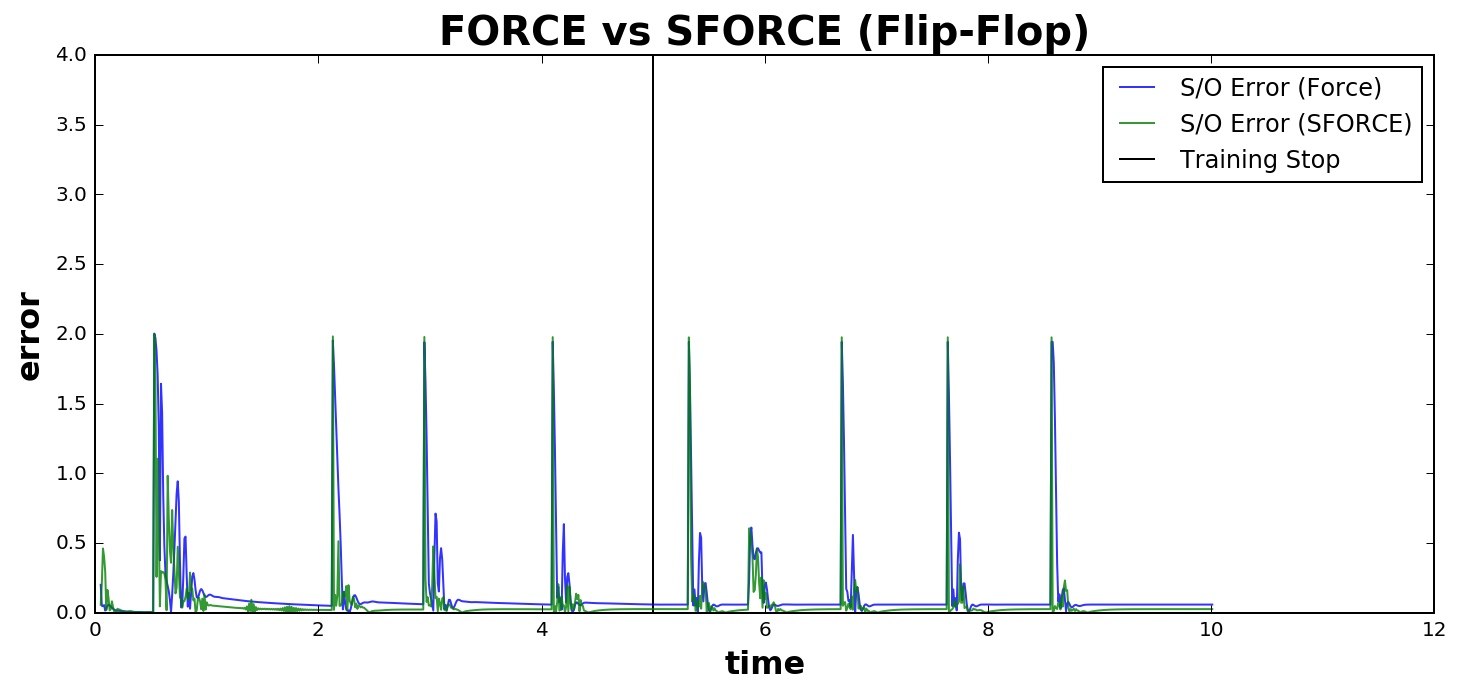

In [39]:
# cross mean signal error
plt.figure(figsize=(12,5))
plot.cross_signal_error(errors, derrors, t, tstop, 
                        title="FORCE vs SFORCE (Flip-Flop)", burn_in=5)

In [42]:
# Setting seed index
ind = 0

Seed: 0


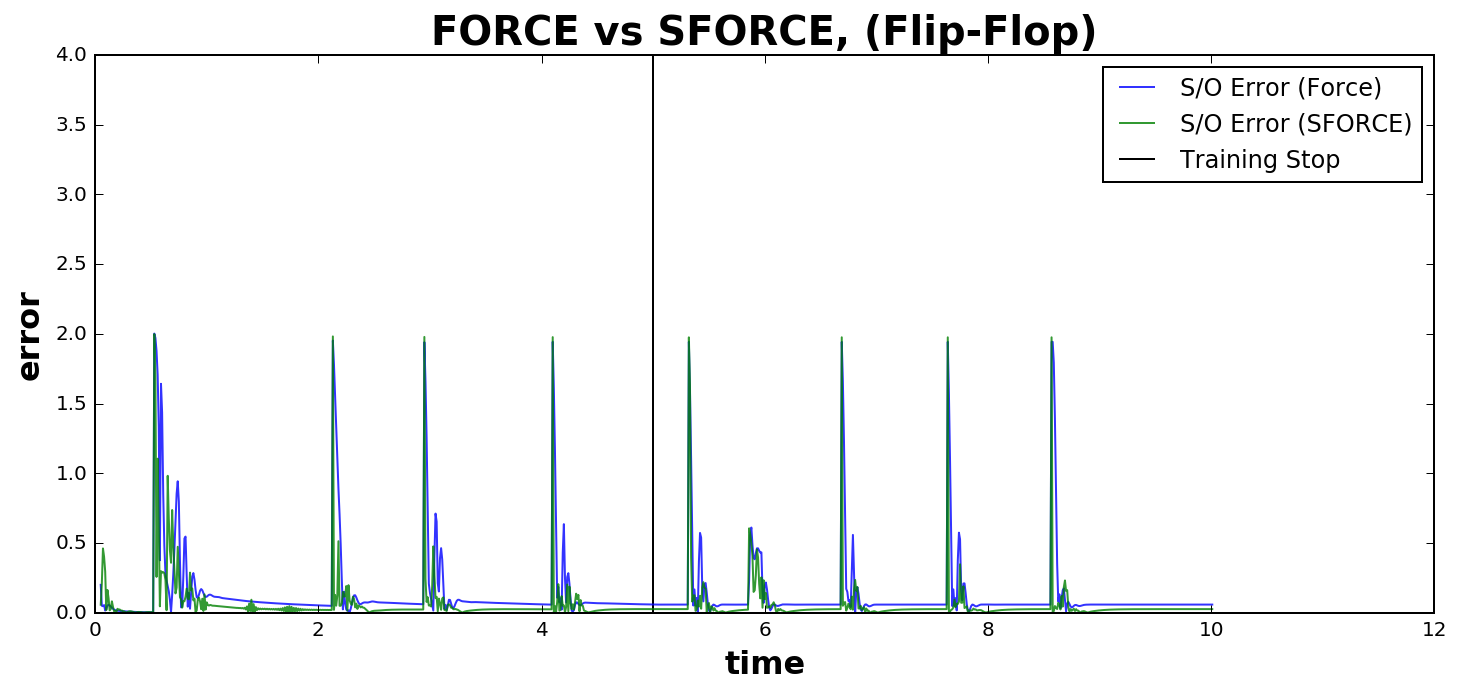

In [43]:
plt.figure(figsize=(12,5))
print("Seed: %d" % ind)
plot.cross_signal_error(errors[ind], derrors[ind], t, tstop, 
                        title="FORCE vs SFORCE, (Flip-Flop)", 
                        burn_in=5, mean=False)
ind+=1

## 3) Lorentz Attractor

In [5]:
# Parameters specified by Abbott 2009.
def lorentz((x, y, z), t0, sigma=10., beta=8./3, rho=28.0):
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [94]:
break_in = 500
T = 1501 # period
x0 = np.random.randn(3) # starting vector
t_= np.linspace(0, 60, T)
lorenz = odeint(lorentz, x0, t_)/20
targets = lorenz[break_in:,0]
t_in = t_[break_in:]

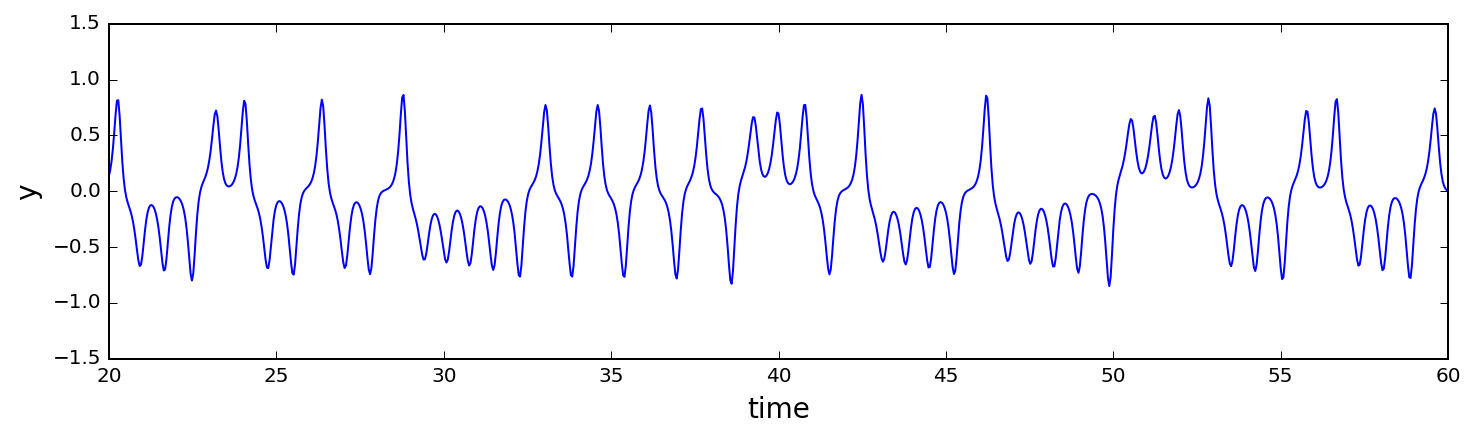

In [95]:
# Visualizing Lorentz attractor
plt.figure(figsize=(12,3))
plt.plot(t_in, targets);
plt.xlim([min(t_in), max(t_in)])
plt.ylim([-1.5,1.5])
plt.xlabel('time', fontsize=14);
plt.ylabel('y', fontsize=14);

In [83]:
10/.01

1000.0

In [96]:
dt = .01       # time step
tmax = 10   # simulation length
tstop = 7  # learning stop time
g = 1.5      # gain factor?
N = 1000      # size of stochastic pool
lr = 1     # learning rate

In [97]:
errors = []
wus = []
zs = []

for seed in seeds:
    print("Seed: %d" % seed)
    
    J, Wz, _, x0, u, w = seedutil.set_simulation_parameters(seed, N, 1, p=(.1,1,1))
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z): 
        return (-x + g * dot(J, tanh_x) + Wz*z)/dt
    
    x,t,z,_,wu,_ = jedi.force(targets, model, lr, dt, tmax, tstop, x0, w)

    zs.append(z)
    wus.append(wu)
        
    error = np.abs(z[1:]-np.array(targets))
    errors.append(error)

errors = np.array(errors)

Seed: 71217
Simulation run-time (wall): 86.612 seconds


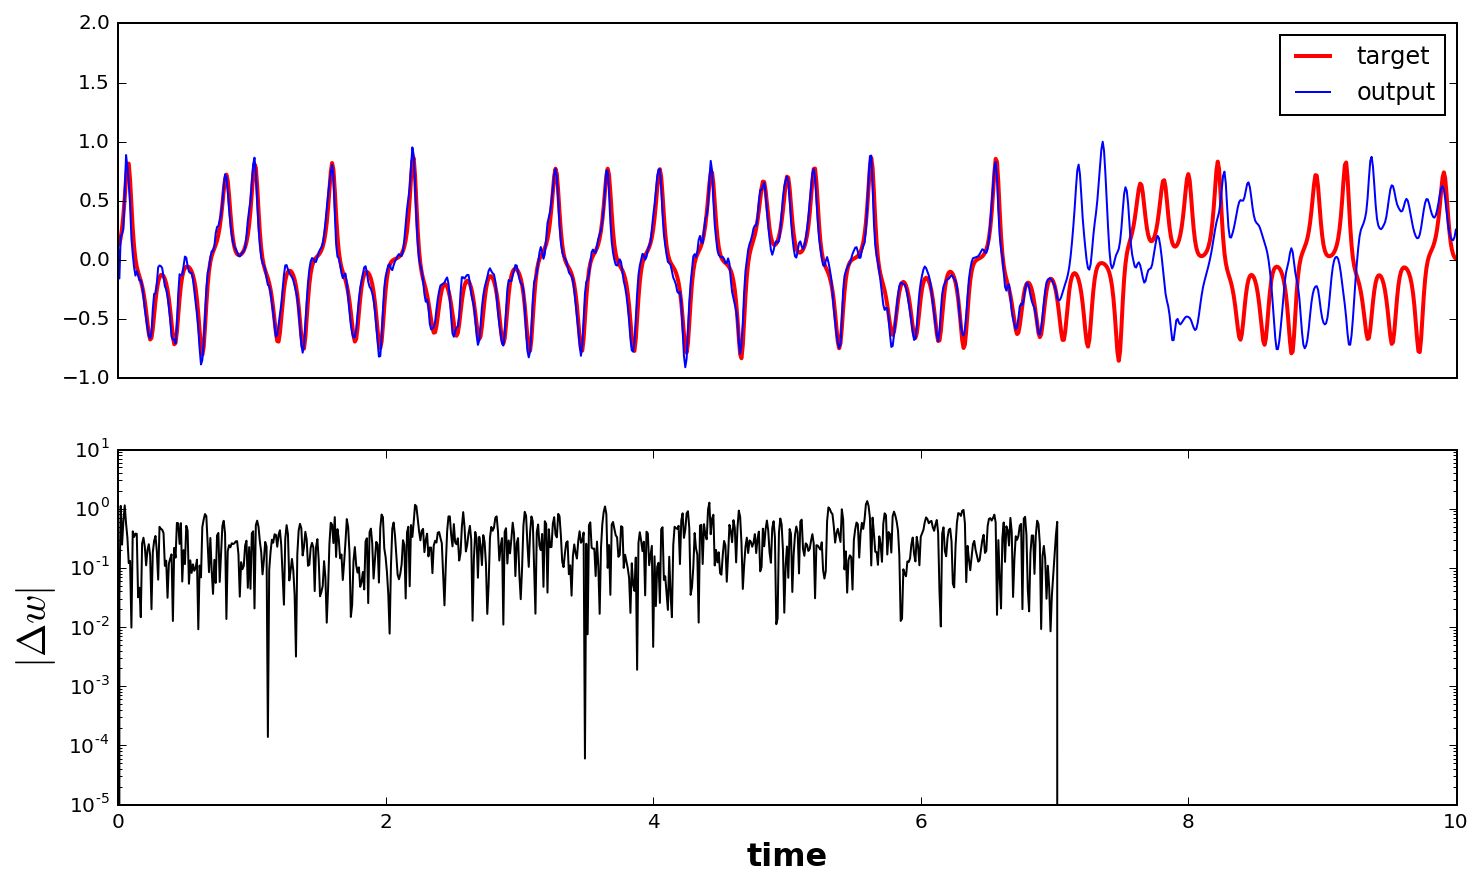

In [98]:
plt.figure(figsize=(12,7))
ind = 0  
tstart = 0
plot.target_vs_output_plus_error(t[tstart:], zs[ind][tstart:], 
                                 wus[ind][tstart:], targets[tstart:], offset=1, ylim=[-1,2])

In [ ]:
plt.figure(figsize=(12,5))
plot.signal_error(errors, t[1:], tstop, title= "FORCE", burn_in=5)

In [143]:
ind = 0

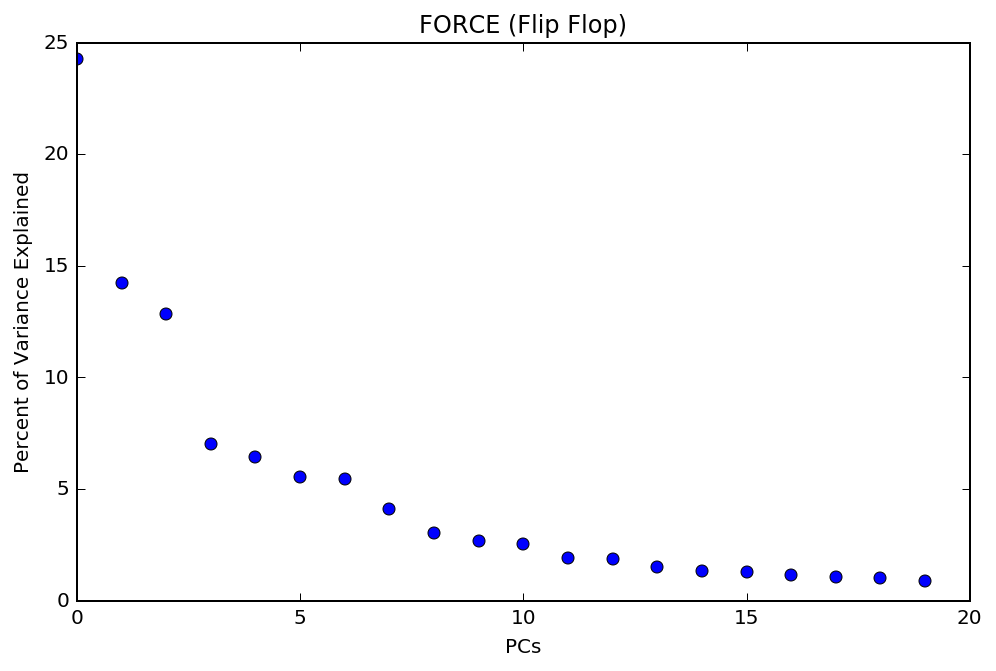

In [144]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("FORCE (Flip Flop)");

In [145]:
pca = PCA(n_components=3)
pca.fit(x)
pca_x = pca.transform(x).T

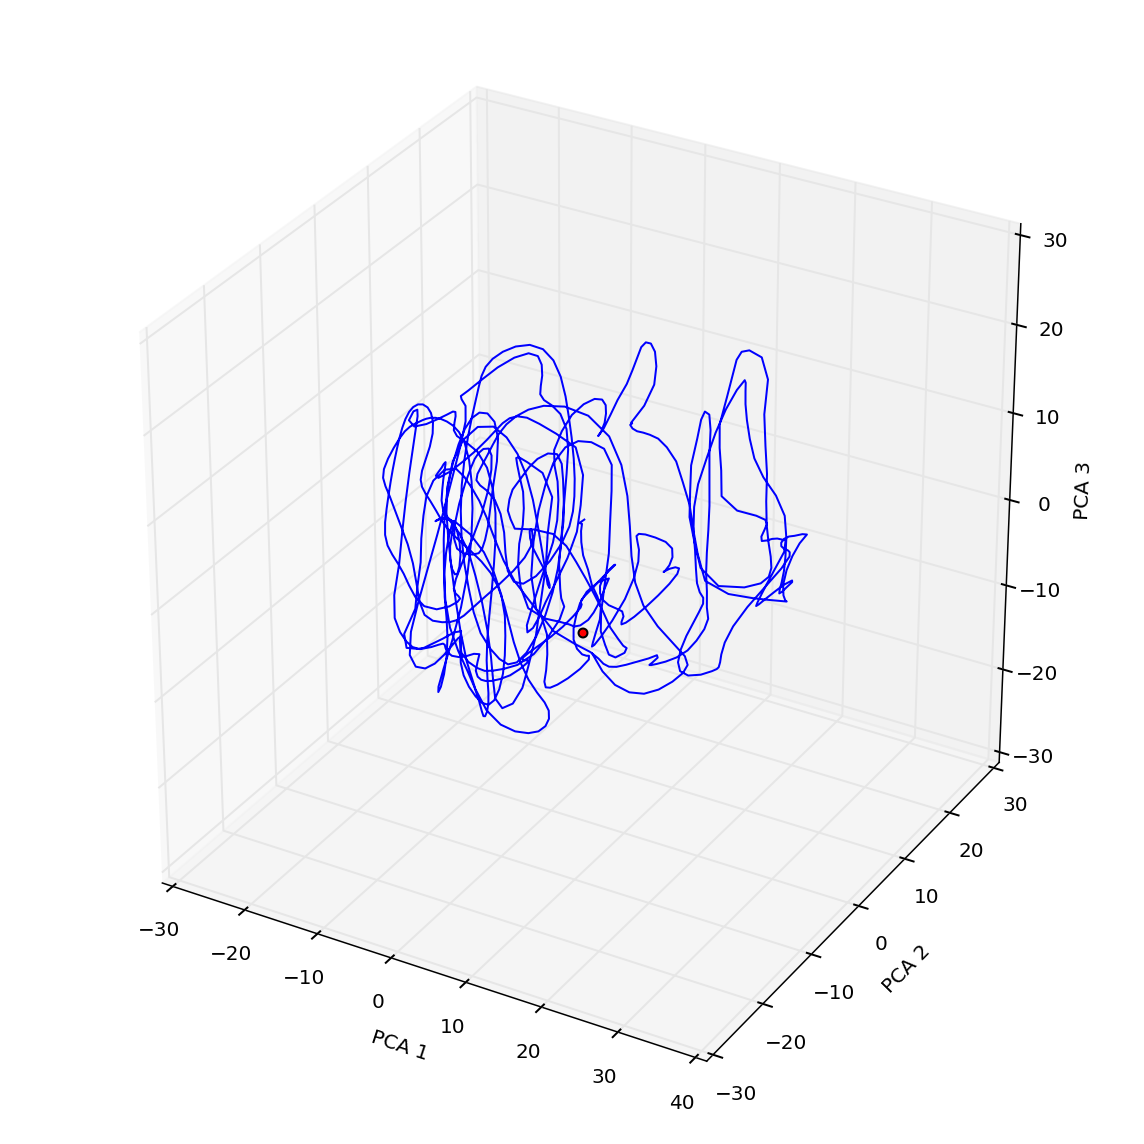

In [146]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_3dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

In [93]:
dt = .01       # time step
tmax = 3 # simulation length
tstop = 2  # learning stop time
g = 1.5      # gain factor?
N = 1000      # size of stochastic pool
lr = 1      # learning rate
rho = 100

In [94]:
derrors = []
wus = []
zs = []

for seed in seeds:
    print("Seed: %d" % seed)
    J, Wi, _, x0, u, w = seedutil.set_simulation_parameters(seed, N, 1, p=(.1,1,1))
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z): 
        return -x + g * dot(J, tanh_x) + dot(z, Wi)
    
    x,t,z,_,wu,_ = jedi.sforce(rho, targets, model, lr, dt, tmax, tstop, x0, w)

    zs.append(z)
    wus.append(wu)
        
    derror = np.abs(z[1:]-np.array(targets))
    derrors.append(derror)
    
derrors = np.array(derrors)

Seed: 24808
Simulation run-time (wall): 34.611 seconds


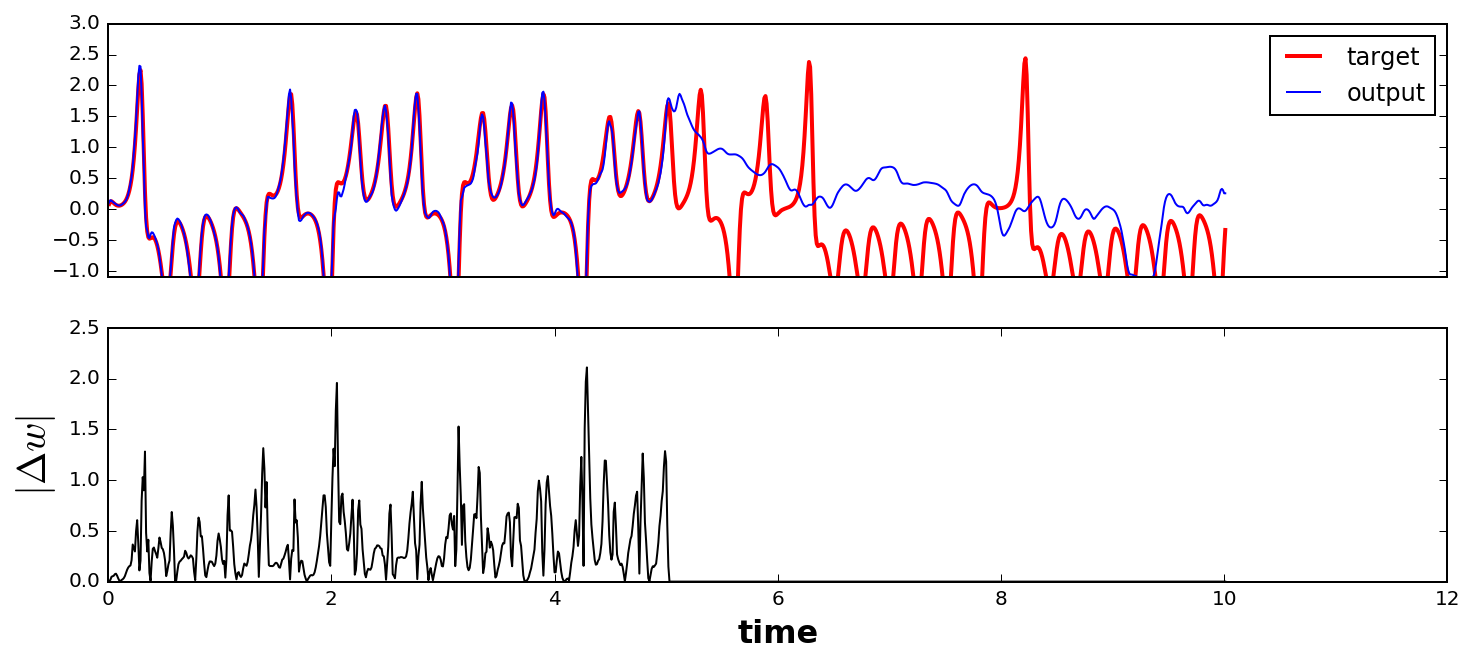

In [95]:
plt.figure(figsize=(12,5))
ind = 0 
plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=1, log=False)

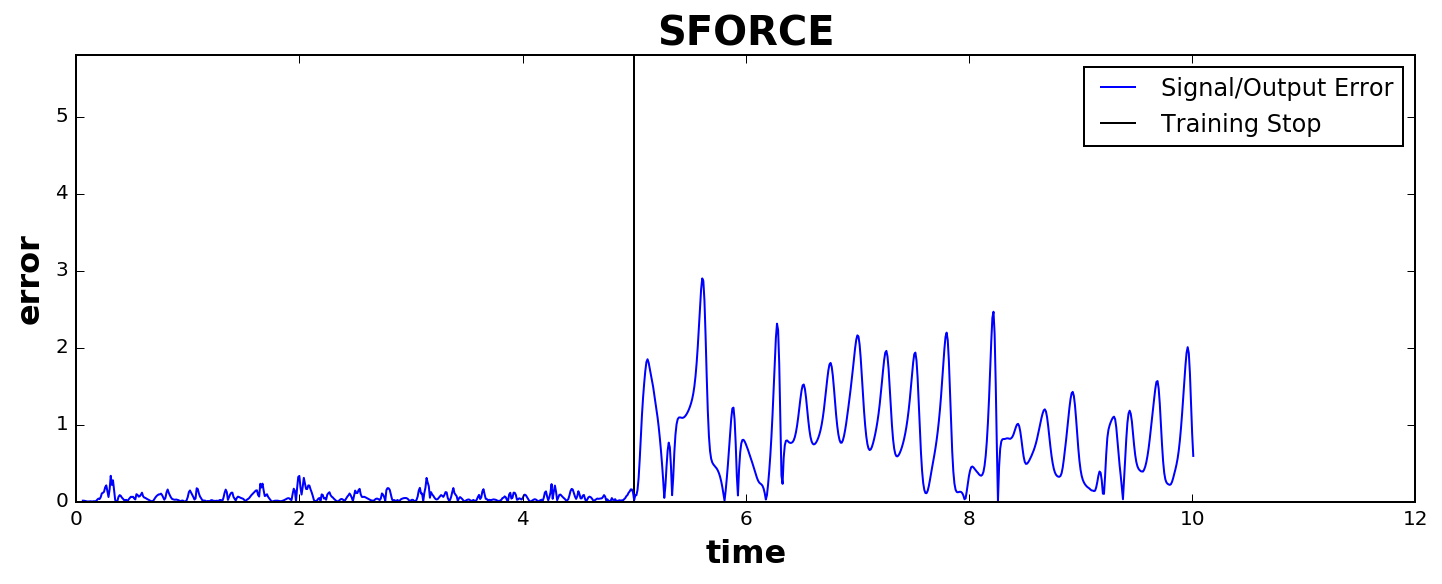

In [96]:
plt.figure(figsize=(12,4))
plot.signal_error(derrors, t[1:], tstop, title= "SFORCE", burn_in=5)

Seed: 0


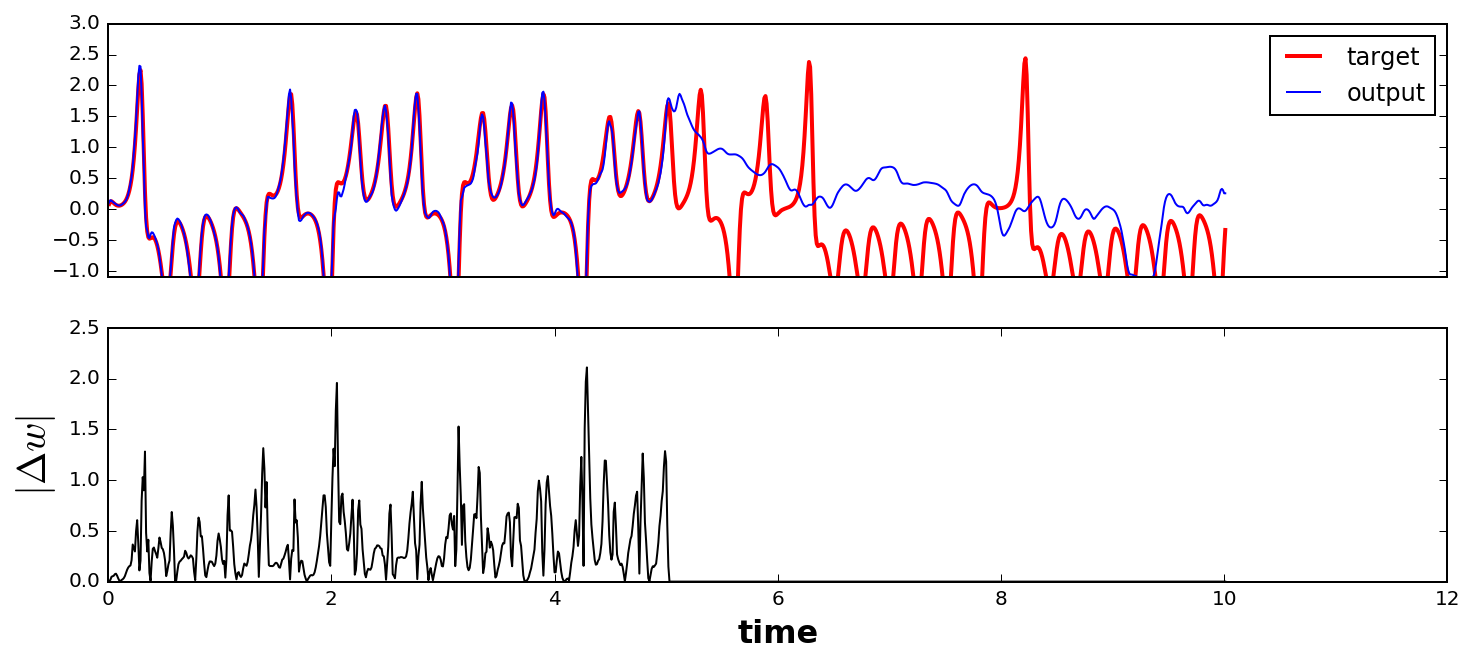

In [97]:
plt.figure(figsize=(12,5))
print("Seed: %d" % ind)
plot.signal_error(derrors[ind], t[1:], tstop, 
                  title= "SFORCE", burn_in=5, mean=False)
plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=1, log=False)
ind+=1

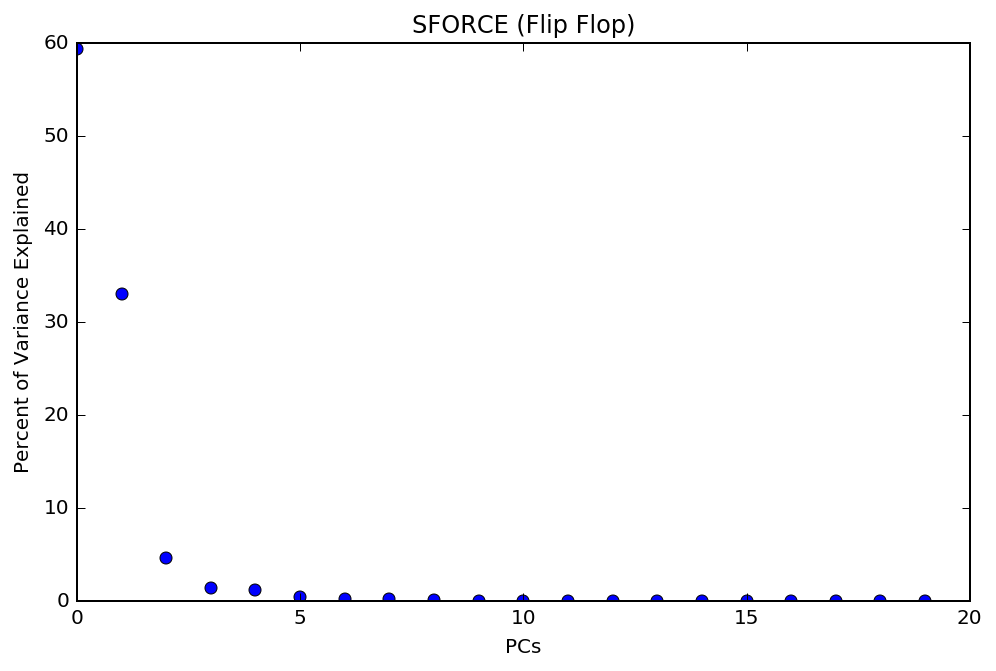

In [98]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("SFORCE (Flip Flop)");

In [99]:
pca = PCA(n_components=3)
pca.fit(x)
pca_x = pca.transform(x).T

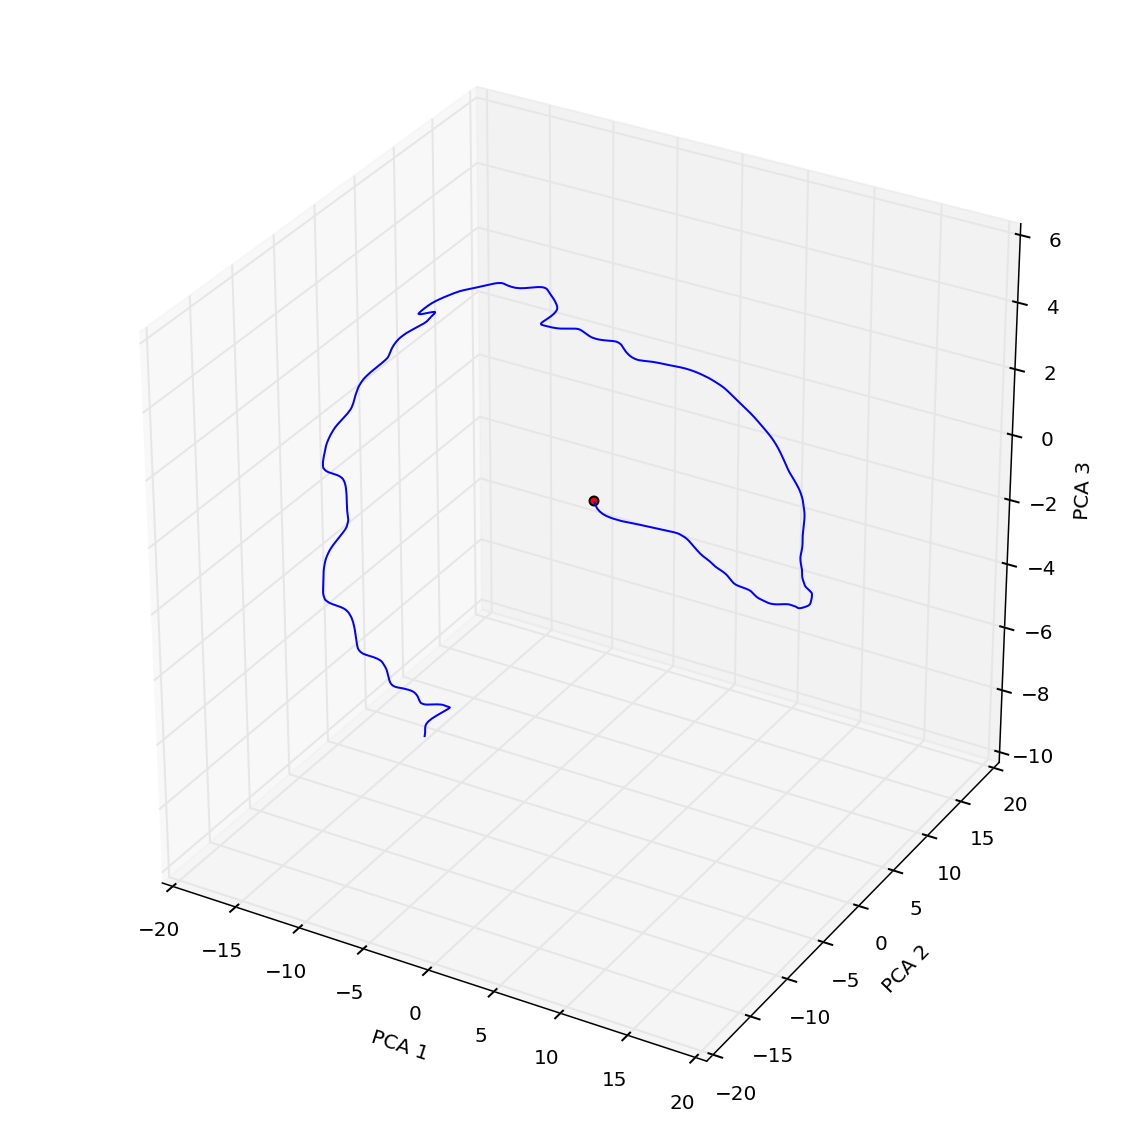

In [101]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_3dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

In [ ]:
# cross mean signal error
plot.cross_signal_error(errors, derrors, t[1:], tstop, 
                        title="FORCE vs SFORCE (Lorentz)", burn_in=5)